# 01 plot & explore stock information

This notebooks is an example of how to plot sentiment score & overlap it with financial information. It assumes that consensus of sentiment was downloaded from [this link](https://drive.google.com/file/d/1IhaHg2hhdufKtGsyLlT2F2gCtYk7xIwc/view?usp=sharing) & financial data was prepared with `scripts/save_financial_data.py`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from internetwisdom.analysis.sentiment import LocalConsensusStorage
from internetwisdom.analysis.finance import (
    plot_comprehensive_dashboard,
    find_momentum_signals,
    plot_rolling_signal_diagnostics,
    prepare_base_stock_data,
    analyze_and_plot_stock,
    train_walk_forward_family, 
    plot_param_heatmap,
    plot_slice_scatter,
    plot_sentiment_period,
    find_suspicious_fits,
    backtest_family_prediction
)
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
# set up storage for sentiment & stock price data
CONSENSUS_DATA_PATH = Path('../consensus_data')
FINANCIAL_DATA_PATH = Path('../data/financial_data.parquet')
TEST_TICKER = 'F'
START_DATE = '20170101'
END_DATE = '20250701'

In [14]:
consensus_storage = LocalConsensusStorage(base_path=CONSENSUS_DATA_PATH)
financial_data = pd.read_parquet(FINANCIAL_DATA_PATH)
financial_data['Date'] = pd.to_datetime(financial_data['date'])
financial_data.set_index('Date', inplace=True)
financial_data.tail()

,date,Open,High,Low,Close,Volume,Ticker
Date,,,,,,,
2025-07-10,2025-07-10,29.32,29.320000,29.320000,29.320000,500.0,ZZZ
2025-07-11,2025-07-11,29.50,29.540001,29.500000,29.540001,500.0,ZZZ
2025-07-14,2025-07-14,30.41,30.410000,29.775999,29.775999,900.0,ZZZ
2025-07-15,2025-07-15,29.52,29.535000,29.496000,29.496000,1300.0,ZZZ
2025-07-16,2025-07-16,29.59,29.726000,29.590000,29.726000,1100.0,ZZZ


Let's just plot how many days with sentiment we have for each ticker

<Axes: xlabel='ticker', ylabel='n_days'>

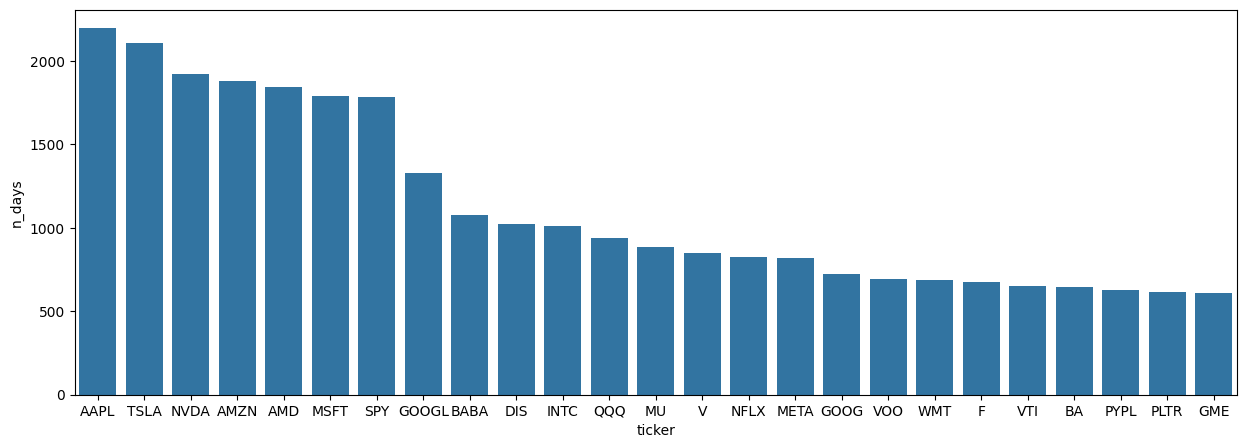

In [15]:
f_tickers = financial_data.Ticker.unique()
tickers_with_counts = {(k,len(v)) for k, v in consensus_storage.ticker_index.items() if k in f_tickers}
tickers_with_counts = sorted(tickers_with_counts, key=lambda x: x[1])[::-1]
tickers_with_counts_df = pd.DataFrame(tickers_with_counts, columns=['ticker', 'n_days'])
sample_mention = pd.concat([tickers_with_counts_df.head(25)])
f, ax = plt.subplots(1,1, figsize=(15, 5))
sns.barplot(data=sample_mention, x='ticker', y='n_days')

In [16]:
analyze_and_plot_stock(
    TEST_TICKER, # ticker
    START_DATE, # start date
    END_DATE, # end date
    consensus_storage, # storage for sentiment data
    financial_data, # financial data
    use_log_transform=True, # whether to use log transform for sentiment
    ema_window=55, # EMA window for sentiment
    horizon_days=55, # horizon for forward return analysis
    filter_non_zero_mention=True, # filter out periods with no mentions, but score simply due to EMA smoothing
)

--- Generating Analysis Plots for F (Window: 55) ---


To fit an WLS on our data using rolling window, we can do the following:

In [17]:
plot_rolling_signal_diagnostics(
    ticker=TEST_TICKER,
    date_b=START_DATE,
    date_e=END_DATE,
    consensus_storage=consensus_storage,
    financial_data=financial_data,
    rolling_window_days=220, # Use ~1 year of past data for each fit
    ema_window=55,
    horizon_days=55,
    use_log_transform=True,
    filter_non_zero_mention=True # filter our days that have no mentions, but have score due to EMA
)

--- Generating Rolling Signal Diagnostics for F ---
Rolling Window: 220 days | EMA: 55 days | Horizon: 55 days


Or, using WLS

In [18]:
plot_rolling_signal_diagnostics(
    ticker=TEST_TICKER,
    date_b=START_DATE,
    date_e=END_DATE,
    consensus_storage=consensus_storage,
    financial_data=financial_data,
    rolling_window_days=220, # Use ~1 year of past data for each fit
    ema_window=55,
    horizon_days=55,
    use_log_transform=True,
    filter_non_zero_mention=True, # filter our days that have no mentions, but have score due to EMA
    model_type='WLS' # to give less wegiths to days further in the past
)

--- Generating Rolling Signal Diagnostics for F ---
Rolling Window: 220 days | EMA: 55 days | Horizon: 55 days


To fit a series of model (proper test, no looking into the future)

In [ ]:
df = prepare_base_stock_data(TEST_TICKER, START_DATE, END_DATE, consensus_storage, financial_data, use_log_transform=True)
if df is None:
    raise ValueError("No data available for the specified ticker and date range.")
fit_results = train_walk_forward_family(
    df_raw=df,
    ema_windows=[25, 35, 45],
    horizons=[40, 60],
    rolling_window_days=220, # Use ~1 year of past data for each fit
    re_fit_frequency_days=10, # re-fit every 10 days, so we have the same model for ~2 weeks
    filter_non_zero_mention=True, # filter our days that have no mentions, but have score due to EMA
    min_sentiment_days_in_window=10, # minimum number of days with sentiment in the rolling window
    min_training_days=15,  # to start fitting a model as soon as we have enough data
    p_value_threshold=0.35, # p-value threshold for the model to be considered valid
    model_type='OLS'
)


We can visualize what window for return\hirozon was picked for each prediction period and if there were any suspicious fits

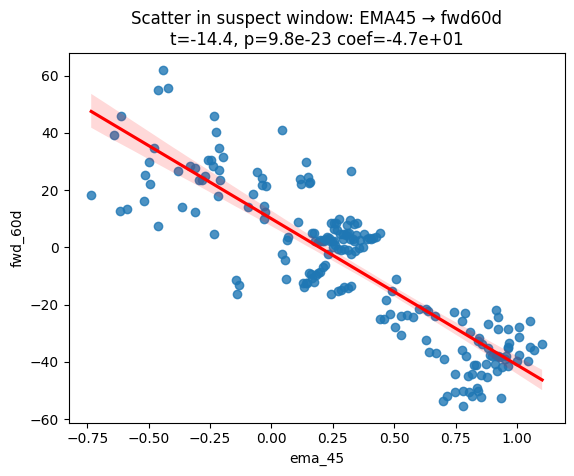

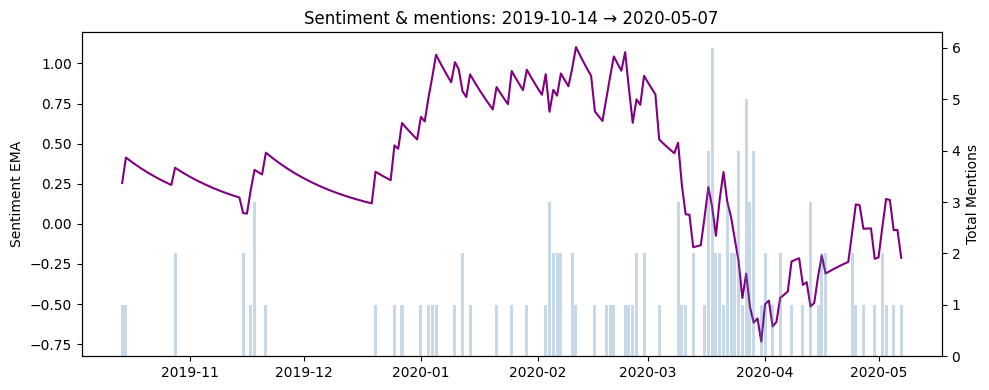

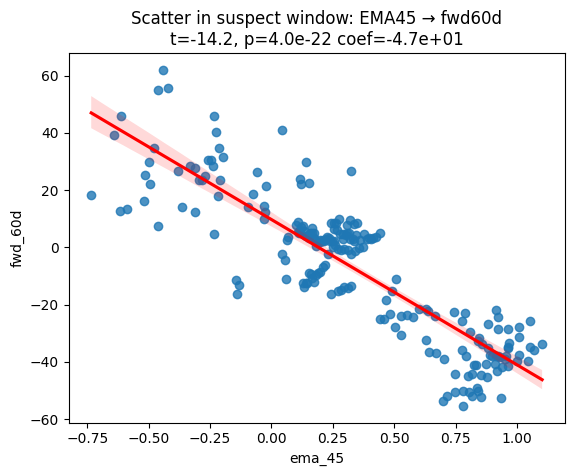

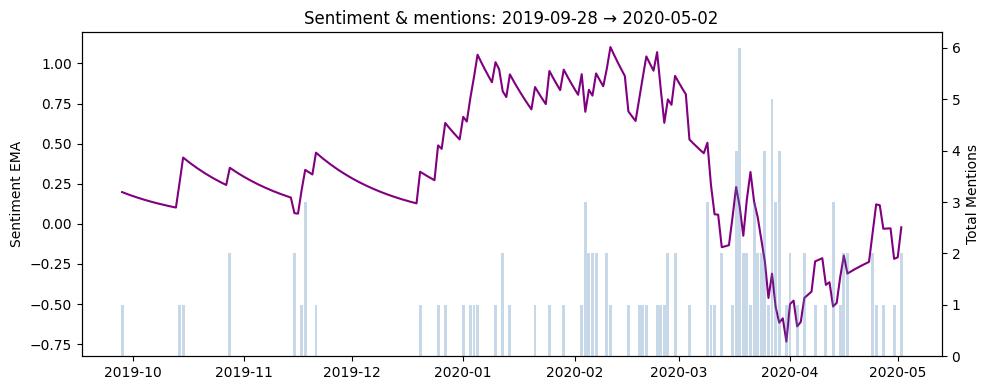

In [20]:
df_with_preds   = fit_results["df"]
models_metadata = fit_results["models_df"]
heatmap_fig_rsq = plot_param_heatmap(models_metadata, "r_squared", "horizon", ticker=TEST_TICKER) # to plot R-squared heatmap as a function of horizon
heatmap_fig_rsq.show()
heatmap_fig_pvalue = plot_param_heatmap(models_metadata, "neg_log_P_value", "horizon", ticker=TEST_TICKER) # to plot p-value heatmap as a function of horizon
heatmap_fig_pvalue.show()
heatmap_fig_rsq = plot_param_heatmap(models_metadata, "r_squared", "span", ticker=TEST_TICKER) # to plot R-squared heatmap as a function of span
heatmap_fig_rsq.show()
heatmap_fig_pvalue = plot_param_heatmap(models_metadata, "neg_log_P_value", "span", ticker=TEST_TICKER) # to plot p-value heatmap as a function of span
heatmap_fig_pvalue.show()
models_metadata = models_metadata.sort_values('neg_log_P_value', ascending=False)
for i in range(1):
    plot_slice_scatter(df_with_preds.set_index("Date"), models_metadata.iloc[i]) # plot best fit
    plot_sentiment_period(df_with_preds.set_index("Date"), models_metadata.iloc[i]) # plot that sentiment period
suspects = find_suspicious_fits(models_metadata)
if suspects.empty:
    print("No suspicious fits found.")
else:
    for i in range(1):
        plot_slice_scatter(df_with_preds.set_index("Date"), suspects.iloc[i])  # plot suspicious fit, top-1
        plot_sentiment_period(df_with_preds.set_index("Date"), suspects.iloc[i])

Now we can run a backtest: for each "trading" period we use model that was trained on the available historical data for that period, and we enter trade based on expected return

In [25]:
results = backtest_family_prediction(
    fit_results['df'],
    fit_results['models_df'],
    filter_non_zero_mention=True, # only use days where we have real signal, not just due to EMA smoothing
    entry_threshold_abs=0.5, # enter when expected return is above 0.5% (absolute value)
    position_size_pct=0.8, # position size as a percentage of the portfolio
    sizing='kelly' # size position based on Kelly criterion
)

Now we can visualize all trades

In [26]:
plot_comprehensive_dashboard(results)